In [3]:

import numpy as np
import torch
from torch.utils.data.dataset import Dataset

import pandas as pd

from einops import rearrange

import scipy.signal as signal



In [86]:
# Make mi dataset
class subject_dataset(Dataset):

	def __init__(self,
			  mat,
			  fs = 250,
			  t_baseline = 0.3,
			  t_epoch = 4):

		super().__init__()

		self.fs = fs
		self.t_baseline = t_baseline
		self.t_epoch = t_epoch

		self.epochs = []
		self.cues = []
		self.dfs = []
		self.timestamps = []

		for i in range(mat.shape[-1]):
			epochs,cues,df = self.load_data(mat,i)
			self.epochs.append(epochs)
			self.cues.append(cues)
			self.dfs.append(df)

		self.epochs = np.concatenate(self.epochs,axis=0)
		# removing 1 to get 0,1 instead of 1,2
		self.cues = np.concatenate(self.cues,0)	- 1	

	def load_data(self,mat,index=0):

		"""
		Loading the epochs,cues, and dataframe for one trial
		For now, we are not removing samples with artifacts
		since it can't be done on the fly.

		Args:
			mat: array
			index: trial index

		Returns:
			epochs: array of epoch electrode data
			cues: array of cues (labels) for each epoch
			df: dataframe of trial data
		"""
		
		electrodes = mat[0][index][0][0][0].squeeze()
		timestamps = mat[0][index][0][0][1].squeeze()
		cues = mat[0][index][0][0][2].squeeze()
		artifacts = mat[0][index][0][0][5]

		epochs,cues = self.create_epochs(electrodes,timestamps,artifacts,cues,
							  self.t_baseline,self.t_epoch,self.fs)
		
		
		df = self.load_df(timestamps,electrodes,cues)
		return epochs,cues,df

	def create_epochs(self,
				   electrodes,
				   timestamps,
				   artifacts,
				   cues,
				   t_baseline,
				   t_epoch,
				   fs):
		
		"""
		creating an array with all epochs from a trial

		Args:
			electrode: electrode data
			timestamps: cue indices
			artifacts: artifact presence array
			cues: labels for cues
			t_baseline: additional time for baseline
			t_epoch: time of epoch
		"""
		
		n_samples = int(fs*t_epoch)
		n_samples_baseline = int(fs*t_baseline)
		epochs = []
		cues_left = []
		for i,j,c in zip(timestamps,artifacts,cues):
			if j==0:
				epochs.append(electrodes[i-n_samples_baseline:i+n_samples,:])
				cues_left.append(c)
		epochs = np.stack(epochs)
		cues_left = np.asarray(cues_left)
		return epochs,cues_left

	def load_df(self,
			 timestamps,
			 electrodes,
			 cues):

		"""
		Loading the channel values and adding a timestamp column.
		Useful for visualizing an entire trial

		Args:
			None
		Returns:
			None
		"""

		timeline = np.zeros_like(electrodes[:,0])

		for t,c in zip(timestamps,cues):
			timeline[t] = c

		df = pd.DataFrame(electrodes)

		df["timestamps"] = timeline

		return df
	
	def trial_preprocess(self, x,*args,**kwargs):
		"""
		Pre-processing step to be applied to entire trial.
		"""
		# Bandpass filter 8-30 Hz
		b, a = signal.butter(4, [8, 30], btype='bandpass', fs=250)
		x = signal.filtfilt(b, a, x, axis=1)
		return x

	def __len__(self):
		return len(self.epochs)

	def __getitem__(self, idx):
		return {"signal": torch.tensor(self.trial_preprocess(rearrange(self.epochs[idx][:, :3], "l c -> c l")).copy()).float(), "cue": self.cues[idx]}

In [87]:
from hydra import compose, initialize
from omegaconf import OmegaConf

from torch.utils.data import DataLoader

from diffusion_model import Diffusion
from networks import LongConv
from utils.kernels_and_diffusion_utils import WhiteNoiseProcess

In [88]:
# Config file


NUM_TIMESTEPS = 1000
SIGNAL_LENGTH = 750

network = LongConv(
    signal_length=SIGNAL_LENGTH,
    signal_channel=3,
    time_dim=10,
    cond_channel=1,
    hidden_channel=5,
    in_kernel_size=17,
    out_kernel_size=17,
    slconv_kernel_size=17,
    num_scales=5,
    decay_min=2,
    decay_max=2,
    heads=3,
    use_fft_conv=False,
)

noise_sampler = WhiteNoiseProcess(1.0, SIGNAL_LENGTH)

diffusion_model = Diffusion(
    network=network,
    diffusion_time_steps=NUM_TIMESTEPS,
    noise_sampler=noise_sampler,
    mal_dist_computer=noise_sampler,
    schedule="linear",
    start_beta=0.0001,
    end_beta=0.02,
)


In [89]:
import scipy.io as io
import os

In [90]:
def load_data(folder,idx):
	path_train = os.path.join(folder,f"B0{idx}T.mat")
	path_test = os.path.join(folder,f"B0{idx}E.mat")
	mat_train = io.loadmat(path_train)["data"]
	mat_test = io.loadmat(path_test)["data"]
	return mat_train,mat_test

In [91]:

data_path = "C:/Repos/Python/motor-imagery-classification/data/2b_iv"
sub = "B01E"

dataset_mat = {}
for i in range(1,2):
	mat_train,mat_test = load_data(data_path,i)
	dataset_mat[f"subject_{i}"] = {"train":mat_train,"test":mat_test}
 

dataset = subject_dataset(
    dataset_mat["subject_1"]["train"],
    fs=250,
    t_baseline=-2,
    t_epoch=5,
)

BATCH_SIZE = 32

train_loader = DataLoader(
    dataset,
    BATCH_SIZE,
)

In [92]:
from torch import optim

In [93]:
optimizer = optim.AdamW(
    network.parameters(),
    lr=1e-3,
)

In [107]:
# Training loop

NUM_EPOCHS = 2

loss_per_epoch = []


for i in range(NUM_EPOCHS):
    
    for batch in train_loader:
        optimizer.zero_grad()
        
        cond = batch["cue"].unsqueeze(-1).unsqueeze(-1).repeat(1, 1, SIGNAL_LENGTH)
        
        loss = diffusion_model.train_batch(batch["signal"], cond=cond)
        loss = torch.mean(loss)
        
        loss.backward()
        optimizer.step()
        
    loss_per_epoch.append(loss.item())
    
    print(f"Epoch {i} loss: {loss_per_epoch[-1]}")
        

Epoch 0 loss: 2370.1796875
Epoch 1 loss: 2261.5625


In [108]:
NUM_SAMPLES = 1

cond_zeros = torch.zeros(NUM_SAMPLES, 1, SIGNAL_LENGTH)
cond_ones = torch.ones(NUM_SAMPLES, 1, SIGNAL_LENGTH)

samples_zeros, _ = diffusion_model.sample(NUM_SAMPLES, cond=cond_zeros)
samples_zeros = samples_zeros.numpy()
np.save("../../data/MI/samples_zeros.npy", samples_zeros)

samples_ones, _ = diffusion_model.sample(NUM_SAMPLES, cond=cond_ones)
samples_ones = samples_ones.numpy()
np.save("../../data/MI/samples_ones.npy", samples_ones)


(1, 3, 750)

In [109]:
import matplotlib.pyplot as plt
from utils.plotting_utils import plot_overlapping_signal

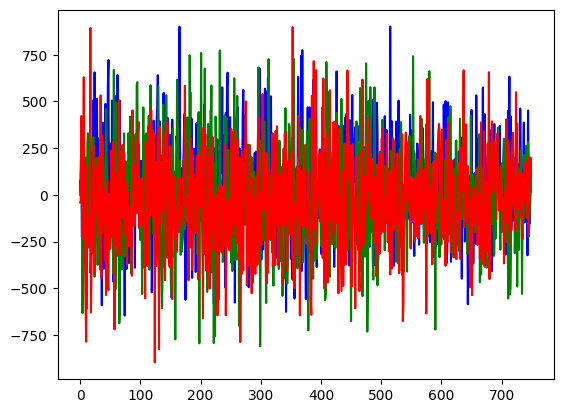

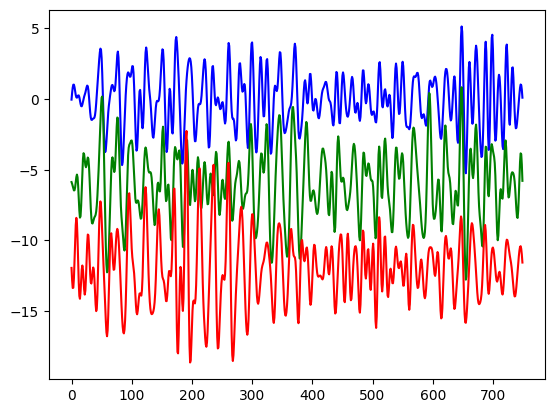

In [116]:
fig, ax = plt.subplots()

num_channels = samples.shape[1]
offset = -6

plot_overlapping_signal(
    fig,
    ax,
    sig=samples[0] + offset * np.arange(num_channels)[:, np.newaxis],
    colors=["blue", "green", "red"],
)

plt.show()

fig, ax = plt.subplots()

num_channels = samples.shape[1]
offset = -6

plot_overlapping_signal(
    fig,
    ax,
    sig=dataset[4]["signal"] + offset * np.arange(num_channels)[:, np.newaxis],
    colors=["blue", "green", "red"],
)

plt.show()